<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
x_train = {
    "type": [0, 1, 1],
    "size": ["small", "small", "medium"],
    "weight": [2.7, 1.8, 1.6]
}
y_train = {
    "pred": [1, 1, 0]
}
ds_train = tf.data.Dataset.from_tensor_slices(tensors=(x_train, y_train))
ds_train = ds_train.batch(batch_size=32)

inputs = {}
inputs["type"] = tf.keras.Input(name="type", shape=(), dtype=tf.int64)
inputs["size"] = tf.keras.Input(name="size", shape=(), dtype=tf.string)
inputs["weight"] = tf.keras.Input(name="weight", shape=(1,), dtype=tf.float32)

outputs = {}
outputs["type"] = tf.keras.layers.CategoryEncoding(
    num_tokens=3, output_mode="one_hot")(inputs["type"])
outputs["size"] = tf.keras.layers.StringLookup(
    vocabulary=["small", "medium", "large"])(inputs["size"])
normalizer = tf.keras.layers.Normalization(axis=None)
normalizer.adapt(ds_train.map(lambda x, y: x["weight"]))
outputs["weight"] =  normalizer(inputs["weight"])

preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

ds_train = ds_train.map(lambda x, y: (preprocessing_model(x), y),
    num_parallel_calls=tf.data.AUTOTUNE)\
    .cache().prefetch(buffer_size=tf.data.AUTOTUNE)

ds_train.element_spec

({'type': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None),
  'size': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'weight': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)},
 {'pred': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})

In [3]:
inputs = {}
inputs["type"] = tf.keras.Input(name="type", shape=(3,), dtype=tf.float32)
inputs["size"] = tf.keras.Input(name="size", shape=(), dtype=tf.int64)
inputs["weight"] = tf.keras.Input(name="weight", shape=(1,), dtype=tf.float32)

embedding = tf.keras.layers.Embedding(input_dim=3, output_dim=4)

h = tf.keras.layers.Concatenate()([
    inputs["type"],
    embedding(inputs["size"]),
    inputs["weight"]
])

outputs = {}
outputs["pred"] = tf.keras.layers.Dense(name="pred", units=1)(h)

training_model = tf.keras.Model(inputs=inputs, outputs=outputs)
training_model.compile(
    loss={"pred": tf.keras.losses.BinaryCrossentropy(from_logits=True)},
    metrics={"pred": [tf.keras.metrics.BinaryAccuracy()]}
)
training_model.fit(x=ds_train, epochs=5)

Epoch 1/5


I0000 00:00:1718807681.523112    3308 service.cc:145] XLA service 0x77ceac03f7b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718807681.523185    3308 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - binary_accuracy: 0.6667 - loss: 0.5964
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.6667 - loss: 0.5917
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6667 - loss: 0.5884
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6667 - loss: 0.5856
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.6667 - loss: 0.5832


I0000 00:00:1718807682.022164    3308 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [4]:
inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)
inference_model.save("model.keras")

x_test = {
    "type": [0],
    "size": ["foo"],
    "weight": [-0.7]
}
ds_test = tf.data.Dataset.from_tensor_slices(tensors=x_test)\
    .batch(batch_size=32)

inference_model = tf.keras.models.load_model("model.keras")
inference_model.predict(ds_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


{'pred': array([[0.51435804]], dtype=float32)}

## Acute Inflammations

The `acute inflammations` was created by a medical expert as a data set to test the expert system, which will perform the presumptive diagnosis of two diseases of the urinary system. You can find out more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).

Attribute information:

Inputs:
- Temperature of patient : 35C-42C
- Occurrence of nausea : yes/no
- Lumbar pain : yes/no
- Urine pushing (continuous need for urination) : yes/no
- Micturition pains : yes/no
- Burning of urethra, itch, swelling of urethra outlet : yes/no

Outputs:
- decision 1: Inflammation of urinary bladder : yes/no
- decision 2: Nephritis of renal pelvis origin : yes/no

In [36]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')

dataset_url = 'https://archive.ics.uci.edu/static/public/184/acute+inflammations.zip'
csv_file = 'datasets/diagnosis.data'

tf.keras.utils.get_file(fname='acute+inflammations.zip',
    origin=dataset_url, extract=True, cache_dir=".")
df = pd.read_csv(csv_file, encoding='utf-16', sep='\t', header=None,
 names=['temp', 'nocc', 'lumbp', 'up', 'mict', 'bis', 'inflam', 'nephr'])
df['temp'] = df['temp'].str.replace(',', '.').astype(np.float32)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    120 non-null    float32
 1   nocc    120 non-null    object 
 2   lumbp   120 non-null    object 
 3   up      120 non-null    object 
 4   mict    120 non-null    object 
 5   bis     120 non-null    object 
 6   inflam  120 non-null    object 
 7   nephr   120 non-null    object 
dtypes: float32(1), object(7)
memory usage: 7.2+ KB


,temp,nocc,lumbp,up,mict,bis,inflam,nephr
0,35.500000,no,yes,no,no,no,no,no
1,35.900002,no,no,yes,yes,yes,yes,no
2,35.900002,no,yes,no,no,no,no,no
3,36.000000,no,no,yes,yes,yes,yes,no
4,36.000000,no,yes,no,no,no,no,no


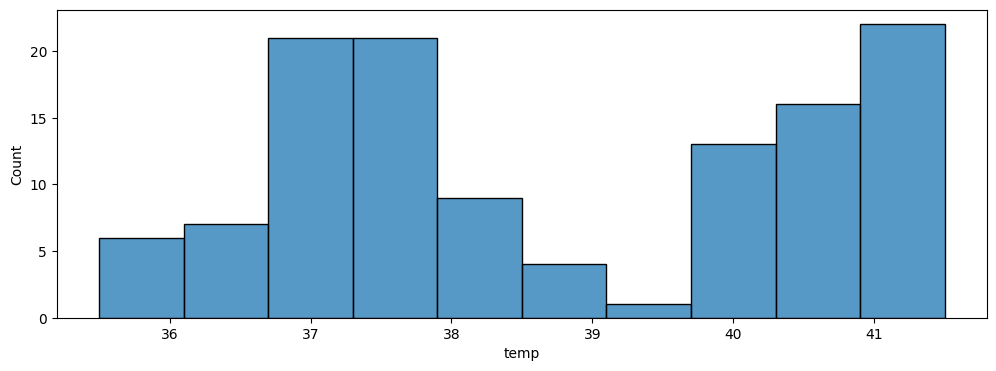

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
g = sns.histplot(x=df['temp'], bins=10)
plt.show()

In [ ]:
dict

In [39]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')

ds = tf.data.Dataset.from_tensor_slices(tensors=dict(df))\
    .batch(batch_size=4)

inputs, outputs = {}, {}
for h in df.select_dtypes(include=float).columns:
    inputs[h] = tf.keras.Input(name=h, shape=(), dtype=tf.float32)
    outputs[h] = tf.keras.layers.Discretization(
        bin_boundaries=[35, 36, 37, 38, 39, 40, 41, 42])(inputs[h])
for h in df.select_dtypes(include=object).columns:
    inputs[h] = tf.keras.Input(name=h, shape=(), dtype=tf.string)
    outputs[h] = tf.keras.layers.StringLookup(max_tokens=2,
        vocabulary=df[h].unique(), num_oov_indices=0)(inputs[h])

preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

ds = ds.map(lambda x: preprocessing_model(x),
    num_parallel_calls=tf.data.AUTOTUNE)\
    .cache().prefetch(buffer_size=tf.data.AUTOTUNE)
ds.element_spec

{'temp': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'nocc': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'lumbp': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'up': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'mict': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'bis': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'inflam': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'nephr': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}

In [ ]:
ds.map(lambda x: ({k:v for k, v in x.items()}, {}))

In [ ]:
df_bank = pd.read_csv("data/bank/bank-full.csv", delimiter=";")
df_bank.info()
df_bank.tail()

In [ ]:
ds_bank = tf.data.Dataset.from_tensor_slices(tensors=dict(df_bank))
ds_bank.element_spec

In [ ]:
inputs = {
    'age': tf.keras.Input(shape=(1,), dtype=tf.int64, name='age')
}

age = tf.keras.layers.Discretization(
    bin_boundaries=[10, 20, 30, 40, 50, 60, 70, 80, 90])(inputs['age'])
age = tf.keras.layers.CategoryEncoding(num_tokens=10, output_mode='one_hot')(age)

outputs = {
    'age': age
}

preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
ds01 = ds_bank.batch(1)
ds01 = ds01.map(lambda x: preprocessing_model(x))
next(iter(ds01))

In [ ]:
df_train, df_test = model_selection.train_test_split(
    df_bank, test_size=0.1, random_state=42)

dict_train = dict(df_train)
ds_train = tf.data.Dataset.from_tensor_slices(tensors={
    k: dict_train[k] for k in dict_train})

dict_test = dict(df_test)
ds_test = tf.data.Dataset.from_tensor_slices(tensors={
    k: dict_test[k] for k in dict_test})
ds_test.element_spec

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

batch_size = 64

ds_train = tf.data.Dataset.from_tensor_slices(tensors=(x_train, y_train))
ds_train = ds_train.map(map_func=lambda x, y: (
    tf.cast(x=x, dtype=tf.float32)/255., y))
ds_train = ds_train.map(map_func=lambda x, y: (
    tf.reshape(x, (784,)), y))
ds_train = ds_train.shuffle(buffer_size=len(ds_train))\
    .batch(batch_size=batch_size)

ds_test = tf.data.Dataset.from_tensor_slices(tensors=(x_test, y_test))
ds_test = ds_test.map(map_func=lambda x, y:
    (tf.cast(x=x, dtype=tf.float32)/255., y))
ds_test = ds_test.map(map_func=lambda x, y: (
    tf.reshape(x, (784,)), y))
ds_test = ds_test.batch(batch_size=batch_size)
print("Element spec:", ds_test.element_spec)

In [ ]:
def get_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    h = tf.keras.layers.Dense(units=64,
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs)
    h = tf.keras.layers.Dropout(rate=0.2)(h)
    outputs = tf.keras.layers.Dense(units=num_classes,
        activation=tf.keras.activations.softmax)(h)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

model = get_model(input_shape=(784,), num_classes=10)
model.summary()

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)

@tf.function
def train_step(x, y):
    logs = {}
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = model.compute_loss(y=y, y_pred=y_pred)

    trainable_vars = model.trainable_variables
    grads = tape.gradient(target=loss,
        sources=trainable_vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(
        grads, trainable_vars))

    for metric in model.metrics:
        if metric.name=="loss":
            metric.update_state(values=loss)
        else:
            metric.update_state(y_true=y, y_pred=y_pred)

    metrics = [m.result() for m in model.metrics]
    logs = {f"train_{k}": v for k, v in metrics[1].items()}
    logs["train_loss"] = metrics[0]

    return logs

@tf.function
def test_step(x, y):
    y_pred = model(inputs=x, training=False)
    loss = model.compute_loss(y=y, y_pred=y_pred)

    for metric in model.metrics:
        if metric.name=="loss":
            metric.update_state(values=loss)
        else:
            metric.update_state(y_true=y, y_pred=y_pred)

    metrics = [m.result() for m in model.metrics]
    logs = {f"test_{k}": v for k, v in metrics[1].items()}
    logs["test_loss"] = metrics[0]

    return logs

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    patience=1)
callbacks = tf.keras.callbacks.CallbackList(model=model,
    callbacks=[reduce_lr], add_history=True)

In [ ]:
num_epochs = 10
start_time = time.time()
history = {
    "train_loss": [], "test_loss": [],
    "train_accuracy": [], "test_accuracy": []
}

logs = {}
callbacks.on_train_begin(logs=logs)

for epoch in range(num_epochs):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for x, y in ds_train:
        logs = train_step(x, y)
    history["train_loss"].append(logs["train_loss"].numpy())
    history["train_accuracy"].append(logs["train_accuracy"].numpy())

    for x, y in ds_test:
        logs = test_step(x, y)
    history["test_loss"].append(logs["test_loss"].numpy())
    history["test_accuracy"].append(logs["test_accuracy"].numpy())

    callbacks.on_epoch_end(epoch=epoch, logs=logs)

callbacks.on_train_end(logs=logs)
print("Time taken: %.2fs"%(time.time() - start_time))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for ax, m in zip(axes, ["loss", "accuracy"]):
    for l in ["train", "test"]:
        g = sns.lineplot(ax=ax, label=l, x=range(num_epochs), y=history[f"{l}_{m}"])
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()